In [221]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy
from sklearn.decomposition import NMF
from nltk.stem.snowball import SnowballStemmer
import re
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Eluvio Data science/ML Challenge:

This challenge is broken down into the following sections that aim to answer the following questions:
0. Summary statistics to get overview of dataset. 
1. User behavior analysis: how many unique users are there? How frequently do they post? How active are users? Can we gain insight into user churn rates?
2. Article classification: what are the most trending topics that users are interested in?
3. Conclusions

## Reading in the dataset in chunks:

In [276]:
# path of dataset:
url = 'https://drive.google.com/file/d/15X00ZWBjla7qGOIW33j8865QdF89IyAk/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

In [297]:
# READ IN INTERESTING DATA
def print_top_chunk(path, chunksize):
    tfr = pd.read_csv(path, chunksize=chunksize, iterator=True)
    top_chunk = tfr.get_chunk(chunksize)
    return top_chunk
    
def extract_data(path, chunksize):
    tfr = pd.read_csv(path, chunksize=chunksize, iterator=True)
    titles_all = []
    titles_votes = [] # tuple of numbers: (upvotes, downvotes)
    date_created = []
    usernames = []
    age_content = []
    categories = []

    chunkcounter = 0
    for chunk in tfr:
    
        if chunkcounter%100 == 0:
            print('chunk: ', chunkcounter)
        chunkcounter += 1
        
        # extract article title:
        titles = chunk['title'].tolist()
        titles_all = titles_all+titles
    
        # extract up and down-vote counts:
        up_votes = chunk['up_votes'].tolist()
        down_votes = chunk['down_votes'].tolist()
        votes = [(up_votes[i], down_votes[i]) for i in range(0,len(up_votes))]
        titles_votes = titles_votes + votes
    
        # extract over_18 column
        age_col = chunk['over_18'].tolist()
        age_content = age_content + age_col

        # extract post usernames
        authors = chunk['author'].tolist()
        usernames = usernames + authors
        
        # extract date:
        dates = chunk['date_created'].tolist()
        date_created = date_created + dates
        
        # extract category:
        category = chunk['category'].tolist()
        categories = categories + category
        
    return titles_all, titles_votes, date_created, usernames, age_content, categories


In [278]:
chunksize = 1000
titles_all, titles_votes, date_created, usernames, age_content, categories = extract_data(path, chunksize)

chunk:  0
chunk:  100
chunk:  200
chunk:  300
chunk:  400
chunk:  500


In [298]:
# print a chunk to visualize data:
top_chunk = print_top_chunk(path, 100)
top_chunk

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews
...,...,...,...,...,...,...,...,...
95,1202579963,2008-02-09,3,0,Iran s nulcear ambitions exposed: US behind it,False,andy4443,worldnews
96,1202566445,2008-02-09,0,0,JESSICA ALBA`s way to shoot nude,False,wahabuddin,worldnews
97,1202567115,2008-02-09,0,0,AL QAEDA LEADERS ARE NOT OPERATING FROM PAKISTAN,False,wahabuddin,worldnews
98,1202588095,2008-02-09,5,0,"White House defends waterboarding, CIA can use...",False,MikaelMN,worldnews


# 0. Brief summery statistics to get an overview of data:
First some simple summary statistics is provided to get a cursory understanding of the data set.

In [289]:
print('Total number of articles: %i' % len(titles_all))
print('Date range of articles: from %s to %s' % (sorted(date_created)[0],sorted(date_created)[-1]))
print('Number of over 18 content: %i' % len([titles_all[i] for i, boo in enumerate(age_content) if boo]))
print('Article categories:')
print(set(categories))

down_votes = [tup[1] for tup in titles_votes]
print('Unique values of down_votes:')
print(set(down_votes))

Total number of articles: 509236
Date range of articles: from 2008-01-25 to 2016-11-22
Number of over 18 content: 320
Article categories:
{'worldnews'}
Unique values of down_votes:
{0}


Thus, the data set consists of 509236 world news articles posted over the course of 9 years, from January of 2008 to November of 2016.  
From the format, this dataset is likely from the Reddit /r/worldnews forum. 

Note also that the down_votes column is uniquely 0 across the entire data set! It provides no signal whatsoever, so it is ignored for the rest of the analysis.
Also, because there are only 320 articles that are labeled as having over 18 content, this is such a small fraction of the data set that it is not analyzed specially.

# 1. User behavior analysis. 
This section tries to answer questions like (1) what are the unique number of users? (2) What is their posting frequency/behavior? The goal is to shed light into the user retention/churn rates. 

In [280]:
uniq_users = set(usernames)
print('Number of unique authors: %i' % len(uniq_users))

Number of unique authors: 85838


Hence actually a comparably small number of authors contribute to the total number of posts.

Next, let us ascertain the post frequency of the authors.

Median number of posts per user: 1
Mean number of posts per user: 5.932524
Standard devition of number of posts per user: 62.282574
Max number of posts per user: 8897


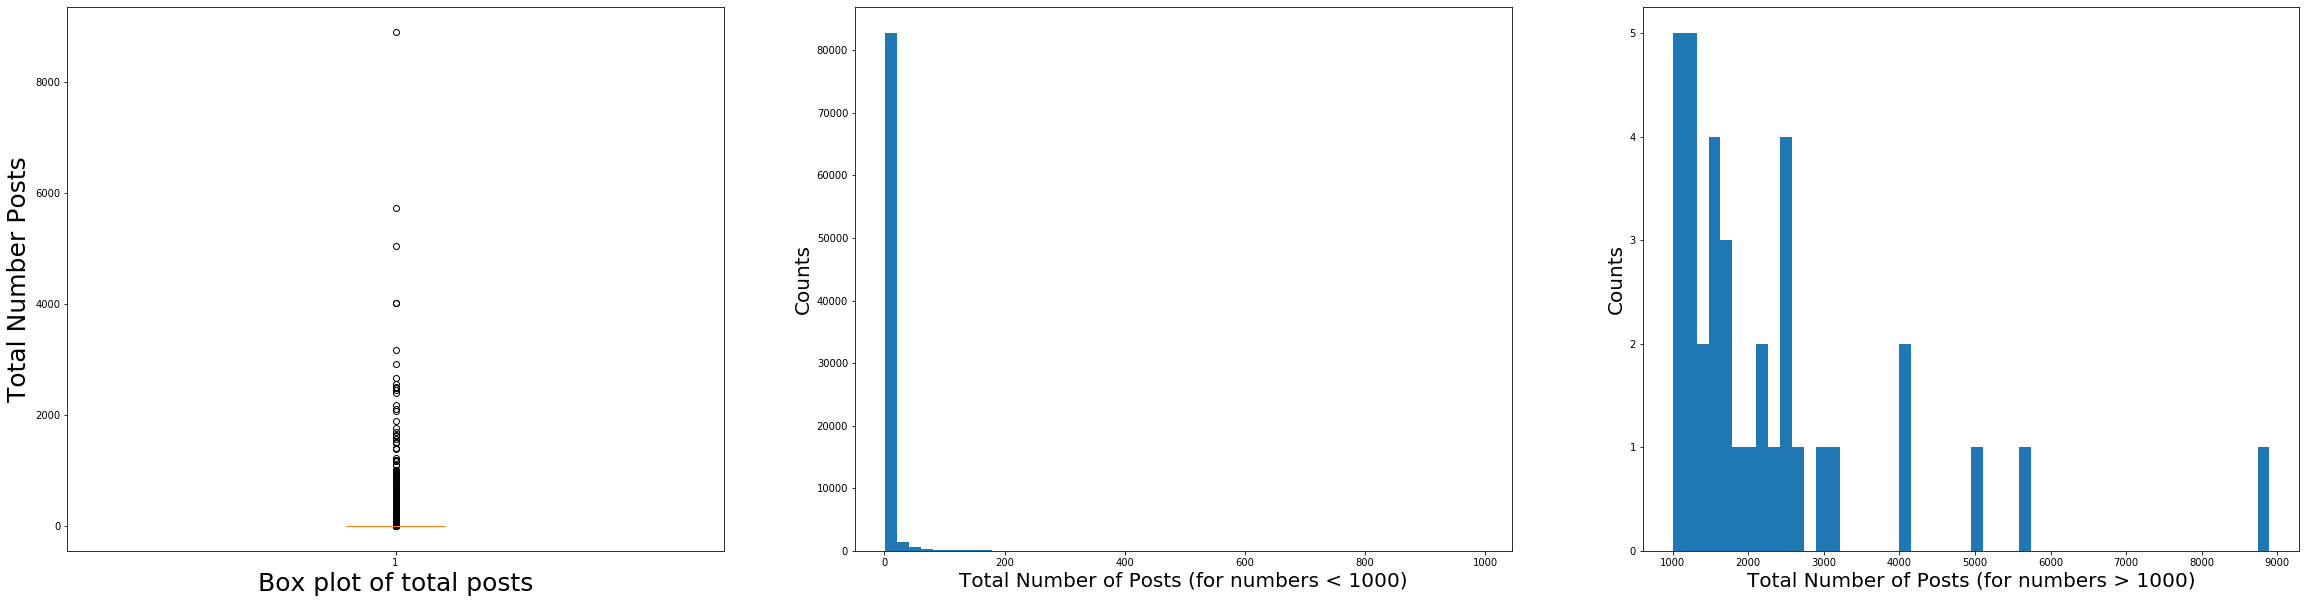

In [281]:
num_user_posts = dict.fromkeys(uniq_users, 0)
for idx, user in enumerate(usernames):
    num_user_posts[user] += 1
    
mega_posters = [user for user, posts in num_user_posts.items() if posts > 1000]


fig, axes = plt.subplots(1,3, figsize=(40,10), sharex=False)
ax0 = axes[0]
ax0.boxplot(num_user_posts.values())  # density=False would make counts
ax0.set_ylabel('Total Number Posts', fontsize=25)
ax0.set_xlabel('Box plot of total posts', fontsize=25)

ax1 = axes[1]
num_posts_lt100 = [x for x in num_user_posts.values() if x < 1000]
ax1.hist(num_posts_lt100, density=False, bins=50)  # density=False would make counts
ax1.set_ylabel('Counts', fontsize=20)
ax1.set_xlabel('Total Number of Posts (for numbers < 1000)', fontsize=20);

ax2 = axes[2]
num_posts_gt100 = [x for x in num_user_posts.values() if x >= 1000]
ax2.hist(num_posts_gt100, density=False, bins=50)  # density=False would make counts
ax2.set_ylabel('Counts', fontsize=20)
ax2.set_xlabel('Total Number of Posts (for numbers > 1000)', fontsize=20);

num_posts = list(num_user_posts.values())
print('Median number of posts per user: %i' % np.median(num_posts))
print('Mean number of posts per user: %f' % np.mean(num_posts))
print('Standard devition of number of posts per user: %f' % np.std(num_posts))
print('Max number of posts per user: %i' % np.max(num_posts))

The above statistics and plots show that most users (specifically, 54640 of 85838) only posted one article. Only a small number of users (36) made over 1000 posts. 

Next, let us plot a distribution of **active user** (defined as users who made at least 100 posts total) behavior over the course of the 9 years to understand if these active users post consistently or sporadically.

In [283]:
# time dynamic stuff: cluster user posts by year (are the mega posters the one who post consistently)
active_posters = [user for user, posts in num_user_posts.items() if posts >= 100]
num_active_posters = len(active_posters)
print('number of active posters: %i' % num_active_posters)

activeposters_post_per_year = np.zeros((num_active_posters, 9))
date_idx_map = dict(zip(range(2008,2017), range(0,9)))

ap = np.array(list(active_posters))
for idx, t in enumerate(titles_all):
    user = usernames[idx]
    
    if num_user_posts[user]>=100:
        user_mp_idx = np.where(ap==user)[0][0]
        year = int(date_created[idx].split('-')[0])
        activeposters_post_per_year[user_mp_idx,date_idx_map[year]] += 1
        
df = pd.DataFrame(activeposters_post_per_year.T, index = range(2008,2017), columns = active_posters)
df

number of active posters: 595


,trojanac,nicksatdown,KevanKing,Moldavite,Orangutan,angierock55,quentinnuk,ffbob666,Mictlantecuhtli,croutonsoup,...,cattleya1709,amlashi,AltThink,MojarraMuncher,r3dd173r,dougmataconis,stefi9100,malchirx,nebm,wndrgls
2008,0.0,0.0,0.0,265.0,40.0,0.0,68.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,56.0,72.0,0.0,0.0,29.0,0.0
2009,0.0,0.0,0.0,14.0,75.0,0.0,78.0,65.0,0.0,0.0,...,0.0,0.0,0.0,0.0,19.0,16.0,0.0,0.0,62.0,0.0
2010,0.0,0.0,0.0,6.0,309.0,0.0,87.0,112.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,32.0,0.0,0.0,5.0,0.0
2011,0.0,0.0,0.0,28.0,176.0,0.0,70.0,0.0,0.0,121.0,...,0.0,0.0,0.0,0.0,15.0,32.0,0.0,0.0,5.0,0.0
2012,0.0,0.0,0.0,9.0,11.0,0.0,34.0,0.0,0.0,49.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,8.0
2013,0.0,25.0,0.0,40.0,14.0,0.0,11.0,0.0,1.0,3.0,...,0.0,0.0,42.0,0.0,20.0,0.0,0.0,0.0,1.0,121.0
2014,129.0,0.0,0.0,0.0,36.0,34.0,7.0,0.0,25.0,1.0,...,7.0,0.0,133.0,1.0,2.0,0.0,2.0,91.0,0.0,71.0
2015,0.0,56.0,3.0,0.0,29.0,64.0,0.0,0.0,119.0,0.0,...,118.0,25.0,90.0,92.0,0.0,0.0,89.0,104.0,0.0,2.0
2016,0.0,58.0,99.0,0.0,11.0,54.0,1.0,0.0,15.0,1.0,...,30.0,143.0,0.0,11.0,0.0,0.0,14.0,19.0,0.0,0.0


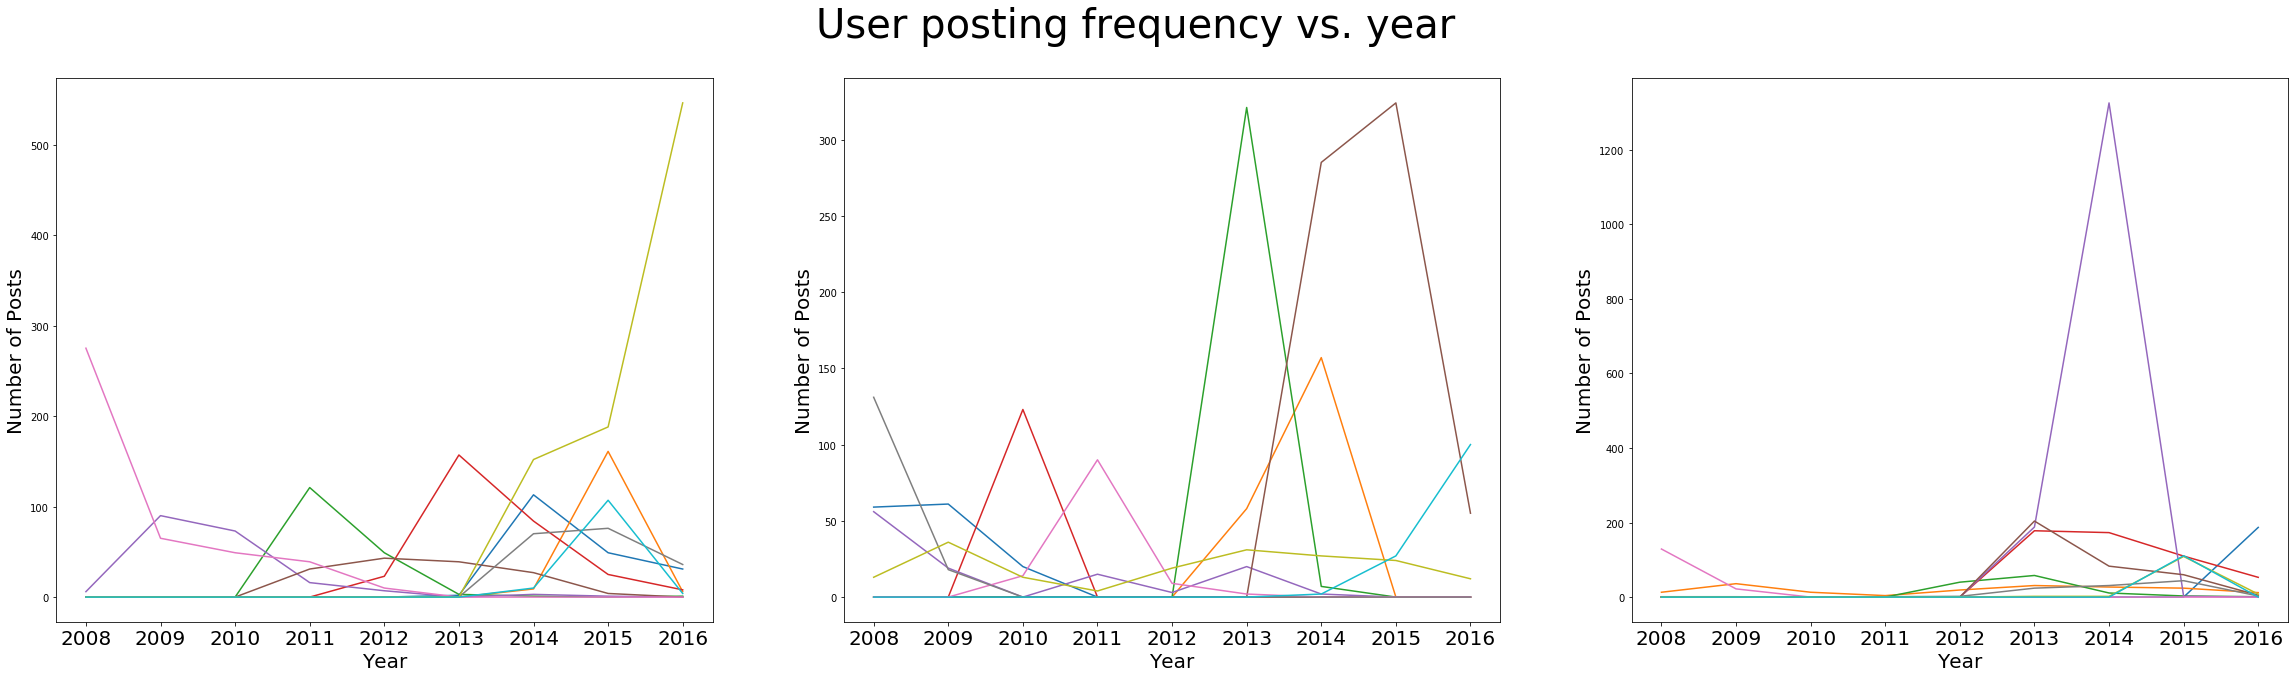

In [150]:
fig, axes = plt.subplots(1,3, figsize=(40,10), sharex=False)
for ax in axes:
    plot_cols = random.sample(range(num_active_posters), 10)
    df_short = df.loc[:,plot_cols]
    ax.set_xticklabels(range(2007,2018), fontsize=20)
    ax.set_ylabel('Number of Posts', fontsize=20)
    ax.set_xlabel('Year', fontsize=20);
    df_short.plot(legend=False, ax = ax)
fig.suptitle('User posting frequency vs. year', y=0.98, fontsize=40)
plt.show()

From the three sets of randomly sampled 10 active posters above, it appears that user posting frequency as a function of year occurs in spurts. In other words, these plots suggest that users rarely remain consistently active over the course of multiple years. More specifically, let us compute a chi-squared statistic:
$$ \chi^2 = \sum_u \sum_y (E_{uy} - O_{uy})^2/E_{uy} $$,
where $u$ sums over the users and $y$ sums over each year. The expected post by user $u$ in year $y$ is simply $E_{uy}$ = (total posts by user $u$ over 9 years)/9. The degree of freedom of this distribution is (users-1) $\times$ (9-1) = 594 $\times $ 8.

In [284]:
expected_posts_per_yr = np.sum(activeposters_post_per_year/9, axis=1).reshape((595, 1))
diff = activeposters_post_per_year - expected_posts_per_yr

chi_sq = np.sum((diff**2)/expected_posts_per_yr)
print('chi_sq = %i' % chi_sq)

pvalue = 1 - scipy.stats.chi2.cdf(chi_sq, 594*8)
print('p-value = %f\n' % pvalue)

chi_sq = 724837
p-value = 0.000000



Thus it is clear that user behavior is not consistently active across all 9 years. This suggests that Reddit can do more to retain user activity by encouraging them to be more active. For example, Reddit could reward users with a special membership status if they post a minimum amount every month.

# 2. Topic Clustering and Classification with NMF:
In this section, machine learning is applied to perform article-classification in order to anwer the question: "what topics amongst world news are trending the most?" Based on the most trending topics, Reddit could tailor the ads shown in /r/worldnews forum to increase revenue. 

The data analysis pipeline is as follows:
1. First, the entire list of 509236 article titles are pre-processed and a bag-of-words is formed. Uninformative words such as stop words, numbers, and non-ascii characters are removed. Words are lower-cased and stemmed to remove redundancies (i.e. plural and singular forms of a word get stemmed into a single word).

2. Next, the tf-idf matrix A is computed and factored according to non-negative matrix factorization (NMF). In other words:
$$ A = UV^T$$, where $A$ is $m \times n$, $U$ is $m \times k$, and $V^T$ is $k \times n$. Note that $m$ is the total number of articles, $n$ is the total number of words chosen as features from the corpus, and $k$ is the number of latent topics. 
We choose $k = 10$ after finding that topics represented by $k>10$ are redundant with those in the first 10.

3. The articles are then classified according to: $\text{topic}_i = \text{argmax}_k U_{ik}$.


### I. Article pre-processing:

In [285]:
# lower-case and stem titles. Notice that the words 'u.s.' are handled with car
def title_stemmer(titles_all, titles_votes, date_created):
    snow_stemmer = SnowballStemmer(language='english')
    
    stemmed_titles = []
    stemmed_votes = []
    stemmed_dates = []

    for idx, title in enumerate(titles_all):
    
        words = title.split(' ')
    
        stems = []
        for w in words:   
            if w.isascii() and not re.search(r'[\d]', w): # this will get rid of numbers and non-ascii chars!
                if w == 'US' or w.lower() == 'u.s.' or w.lower() == 'u.s': # handle 'u.s.' with care. 
                    w = 'usa'
                
                x = snow_stemmer.stem(w.lower())
                stems.append(x)
        
        if len(stems)>0:
            stemmed_titles.append(' '.join(stems))
            stemmed_votes.append(titles_votes[idx])
            stemmed_dates.append(date_created[idx])
            
    return stemmed_titles, stemmed_votes, stemmed_dates

In [286]:
stemmed_titles, stemmed_votes, stemmed_dates = title_stemmer(titles_all, titles_votes, date_created)

In [307]:
print('Total title count after stemming: %i' % len(stemmed_titles))

Total title count after stemming: 509196


### II. Compute document-term-matrix, ignoring stop words:

In [287]:
# define stop words
stop_words = set(text.ENGLISH_STOP_WORDS)

# these are frequently occuring words in the corpus which are too generic to convey any useful meaning.
additional_stop_words = set(['say', 'new', 'news', 'said', 'year', 'world', 'use'])
stop_words = stop_words.union(additional_stop_words)

# now compute the tfidf matrix A
tfidf_vec = TfidfVectorizer(stop_words=stop_words,max_features=20000, max_df=0.95, min_df=2, use_idf=True)
A = tfidf_vec.fit_transform(stemmed_titles)

### III. Perform non-negative matrix factorization to cluster articles into topics:

In [288]:
num_topics = 10
nmf = NMF(n_components=num_topics, random_state=1, alpha=.1, l1_ratio=.5).fit(A)
U = nmf.transform(A)

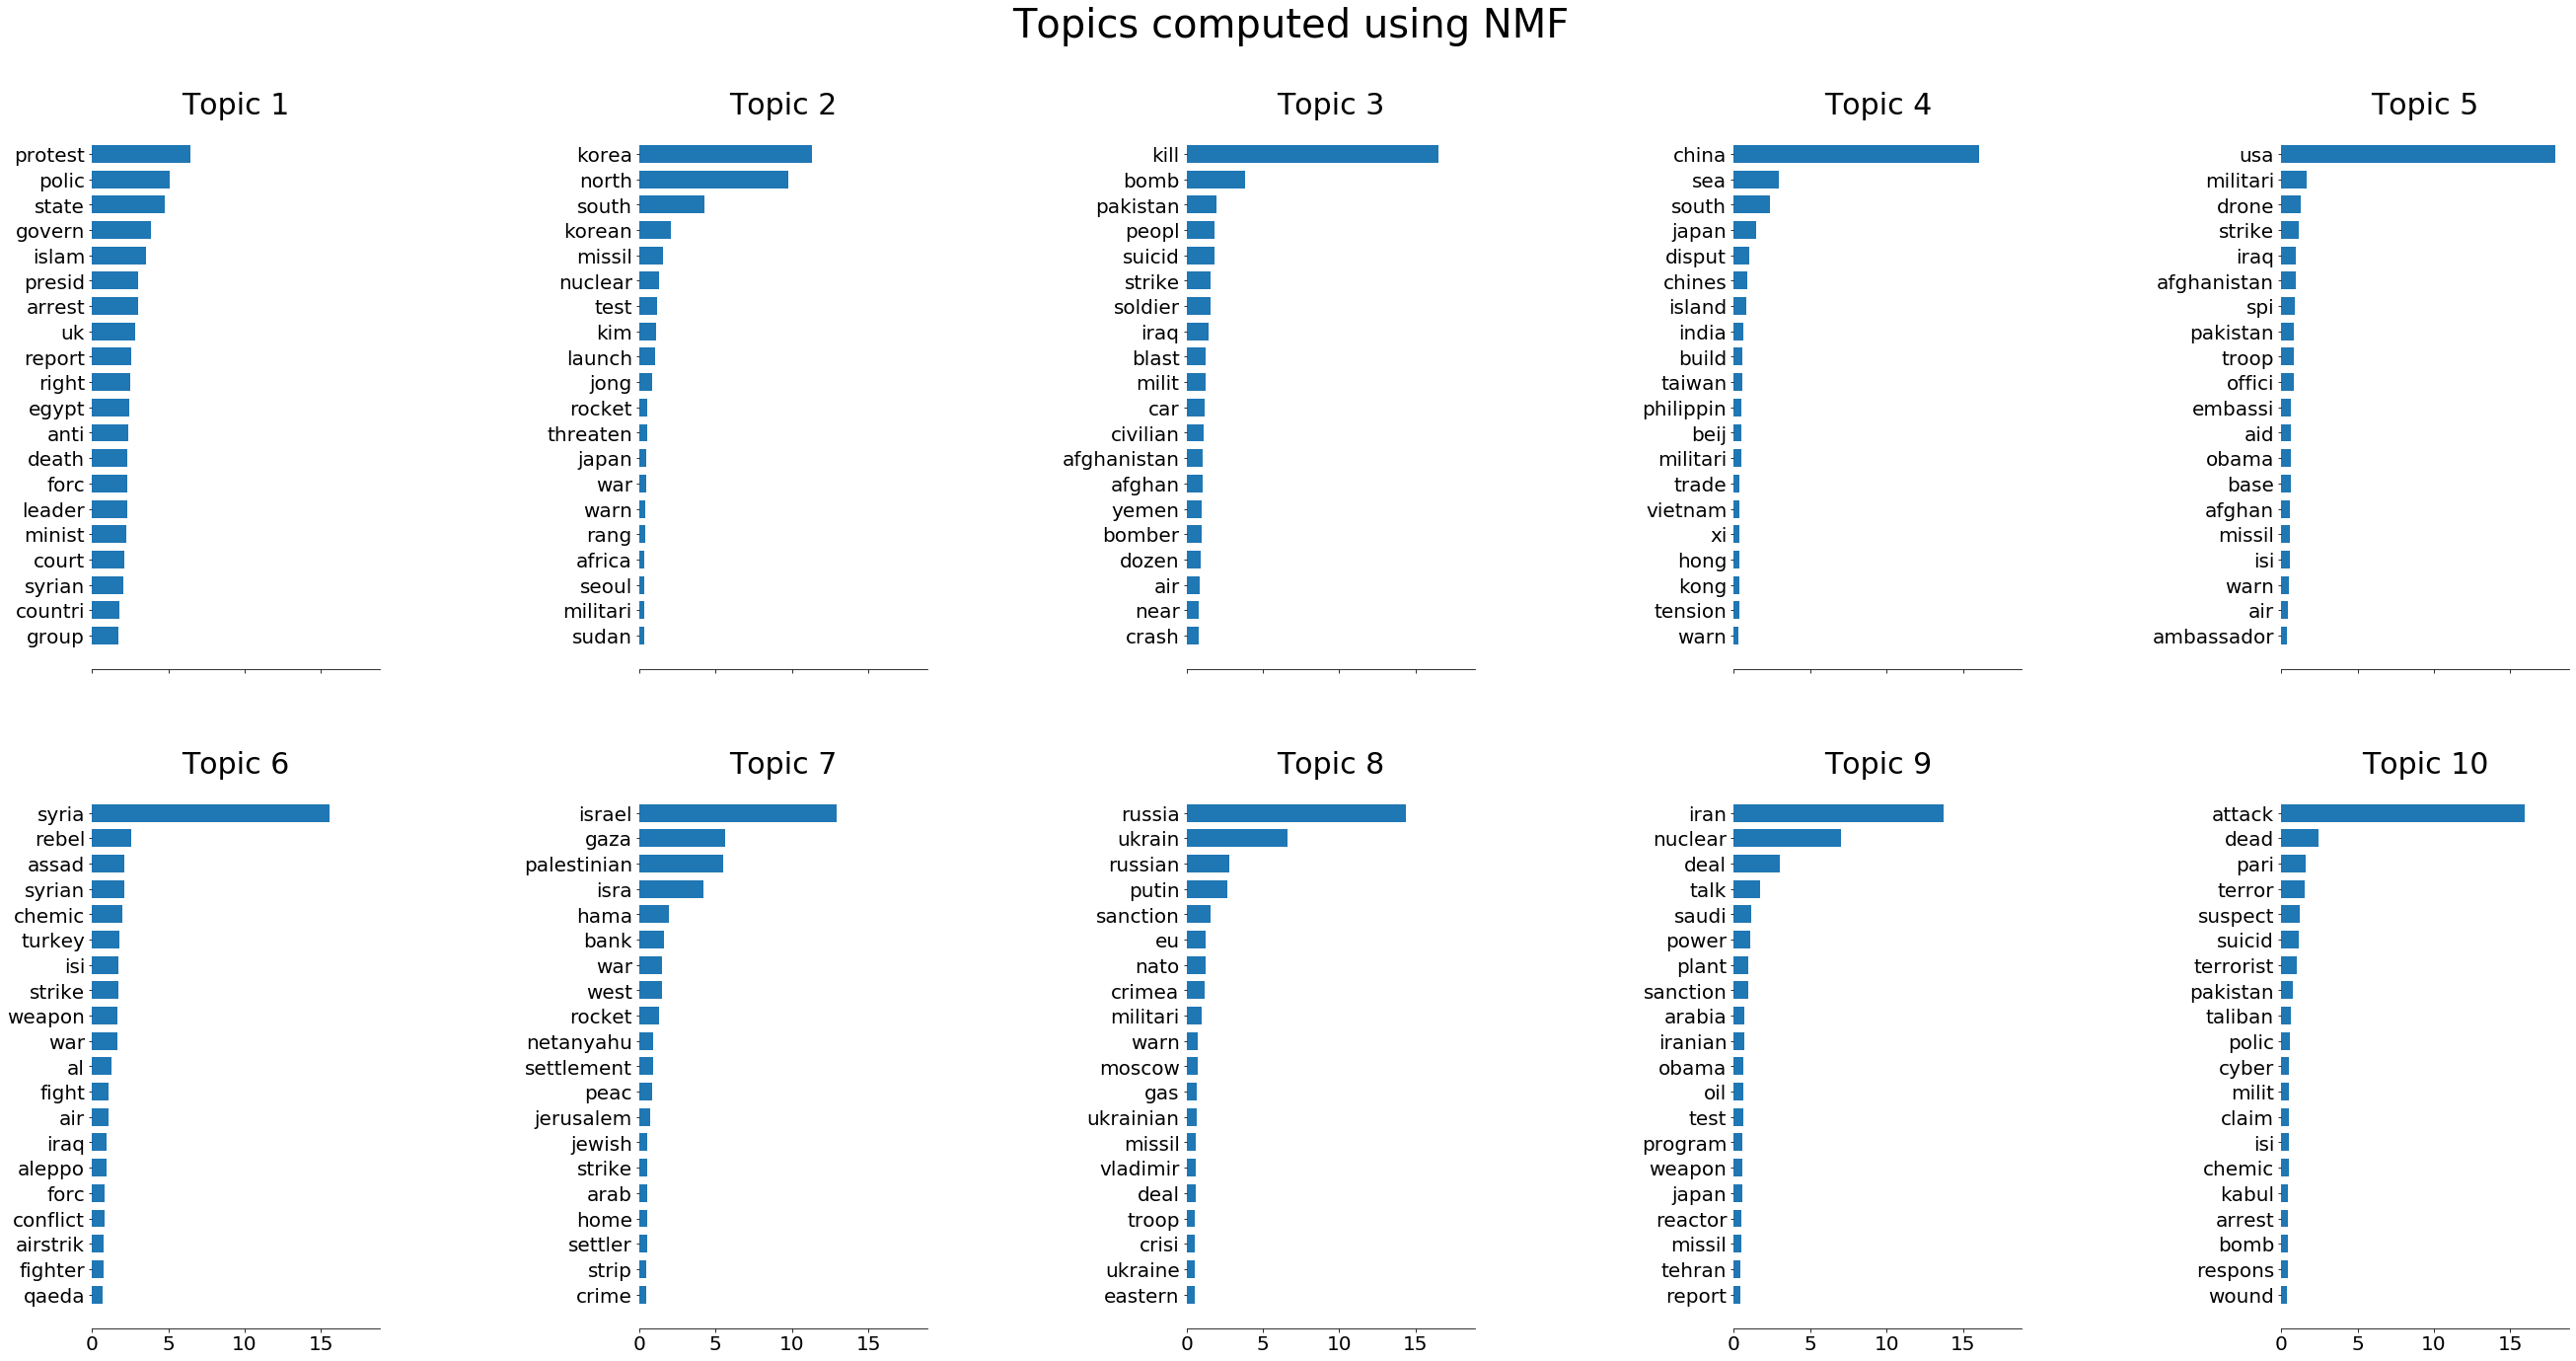

In [299]:
def plot_NMF_topics(nmf, feature_names, n_top_words):
    fig, axes = plt.subplots(2, 5, figsize=(45, 20), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(nmf.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        #print(top_features_ind)
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}', fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle('Topics computed using NMF', fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.2)
    plt.show()

plot_NMF_topics(nmf, tfidf_vec.get_feature_names(), 20)

From the above, we see that many of the topics classify nicely based on country (China, Korea, USA, Syria, Israel, Russian, Iran). Topics 1, 3, and 10 instead describe subject-matter, such as protests (happening in various regions around the world), killings and attacks. Indeed, the latter two topics 3 and 10 seem redundant, for both of them list similar words such as Pakistan, bomb, suicide, military, etc. This is the reason that I chose not to go beyond 10 topics, because many of the topics after 10 are redundant. 

For fun, we can also plot the most popular words across the entire corpus. Note that there is a high correspondence between the most popular words and the clustered topics discovered by NMF above.

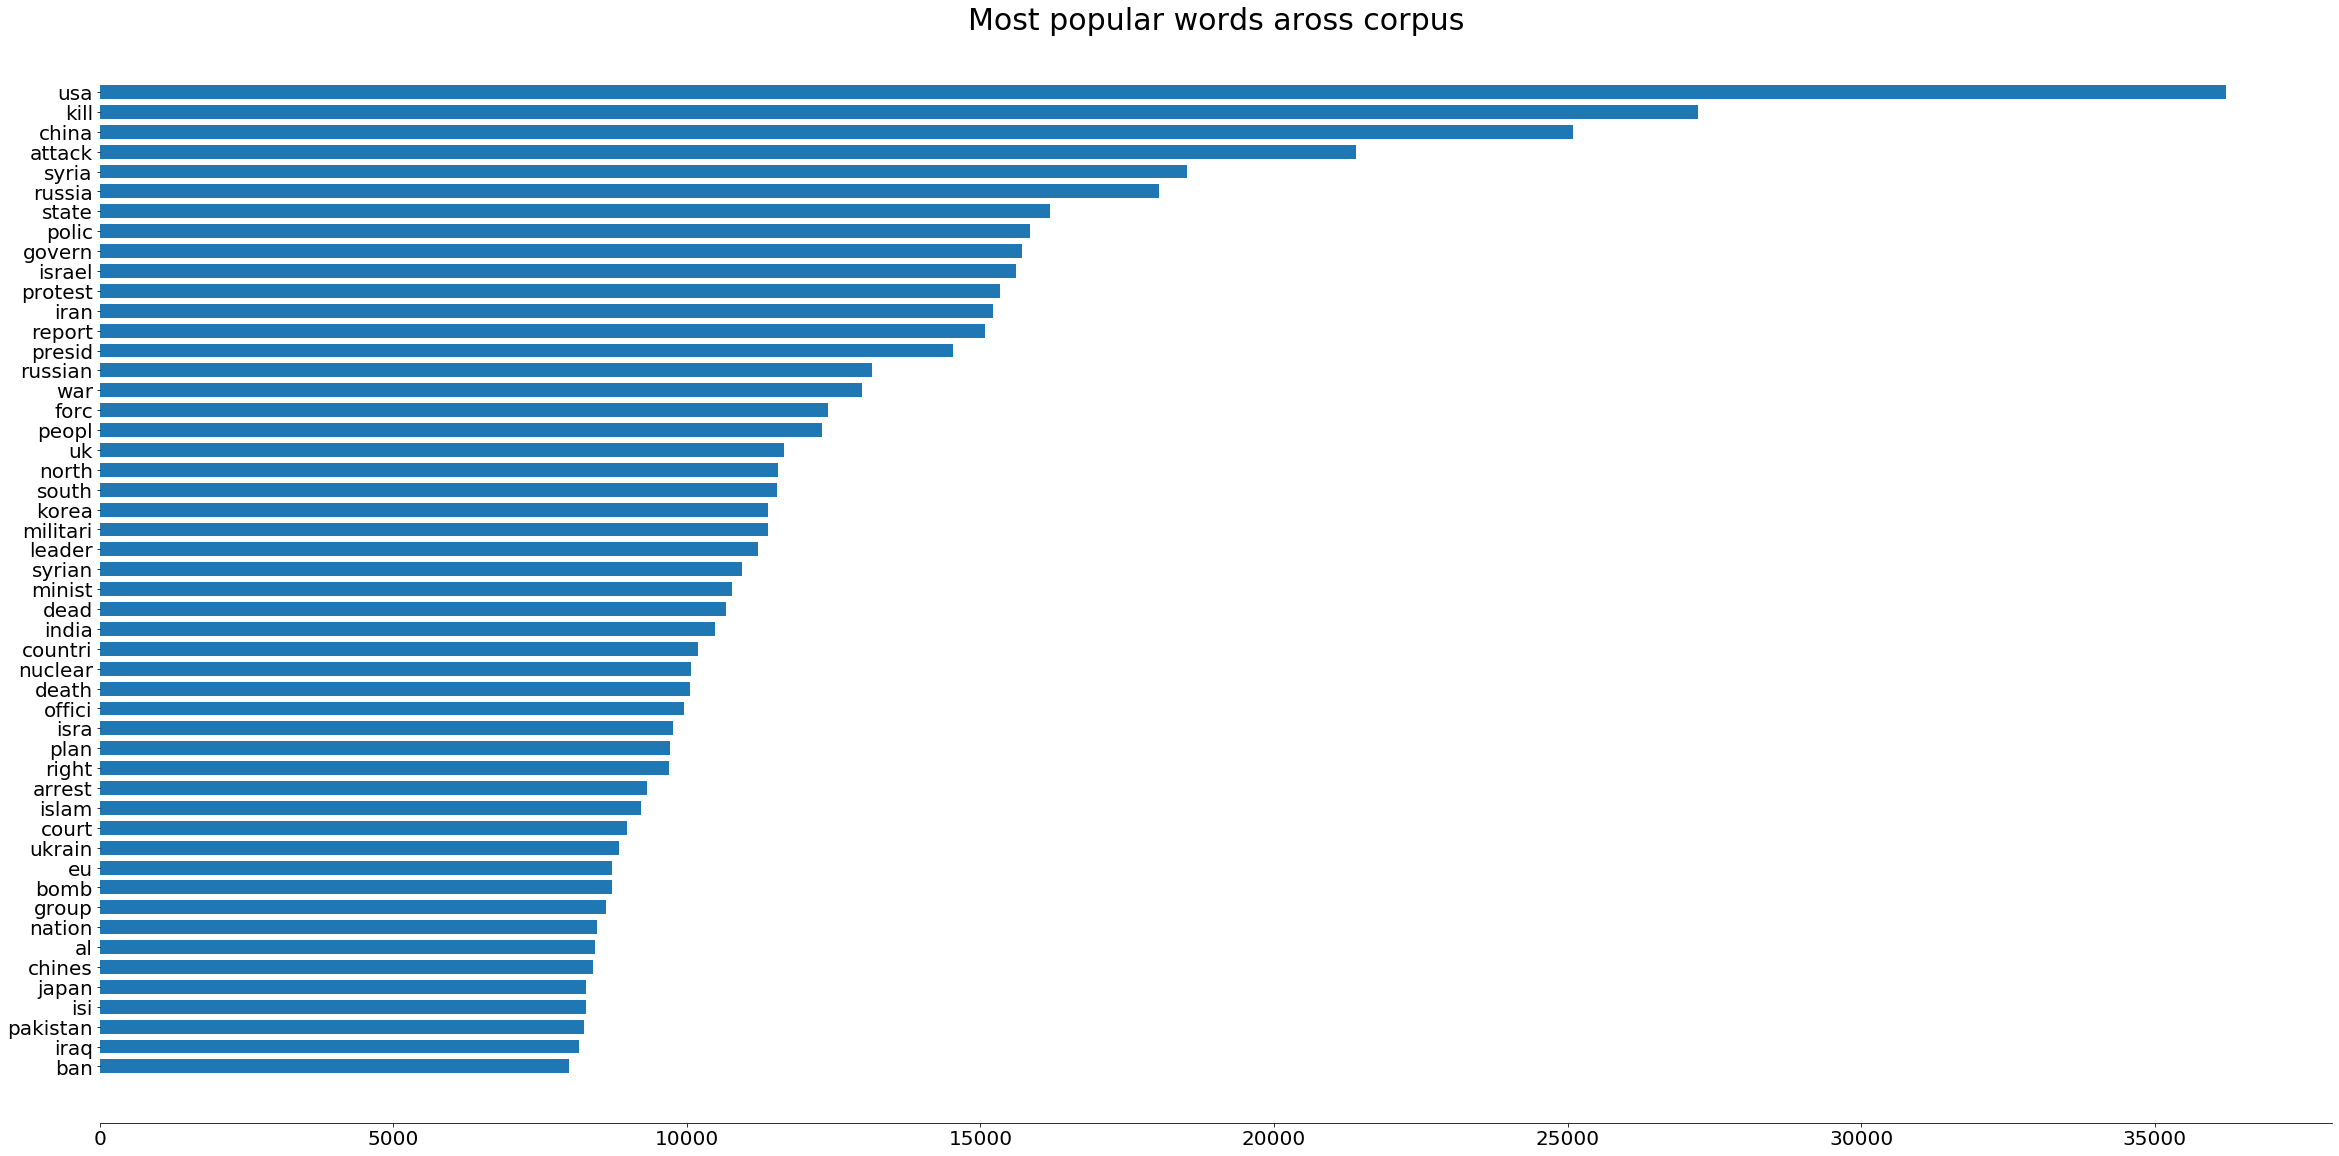

In [300]:
# plot the top words across entire corpus!
def plot_top_words_across_corpus(word_freq, num_words_to_plot):
    top_n_words = [wf[0] for idx, wf in enumerate(word_freq) if idx < num_words_to_plot]
    freqs = [wf[1] for idx, wf in enumerate(word_freq) if idx < num_words_to_plot]
    
    fig, ax = plt.subplots(1,1, figsize=(40, 20), sharex=True)

    ax.barh(top_n_words, freqs, height=0.7)
    ax.set_title('Most popular words aross corpus', fontdict={'fontsize': 30})
    ax.invert_yaxis()
    ax.tick_params(axis='both', which='major', labelsize=20)
    for i in 'top right left'.split():
        ax.spines[i].set_visible(False)


tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=20000, stop_words=stop_words)
tf = tf_vectorizer.fit_transform(stemmed_titles)

sum_words = tf.sum(axis=0)
word_freq = [(w, sum_words[0,idx]) for w, idx in tf_vectorizer.vocabulary_.items()]

word_freq_sorted = sorted(word_freq, key = lambda x:x[1], reverse = True)
plot_top_words_across_corpus(word_freq_sorted, 50)


### IV. Assign every article to a topic and compare upvotes

To conclude, every article $i$ is assigned to a topic according to $\text{topic}_i = \text{argmax}_k U_{ik}$, and the average number of upvotes per topic is computed (defined as total upvotes/articles in topic).

In [301]:
# quantify average number of upvotes per topic:
topic_assignment = np.argmax(np.array(U), axis=1) 
topic_votes = dict.fromkeys(range(0, 10), 0)
topic_num_articles = dict.fromkeys(range(0, 10), 0)

for idx, topic in enumerate(topic_assignment):
    topic_votes[topic] += stemmed_votes[idx][0] # only care about upvotes as downvotes carries no information. 
    topic_num_articles[topic] += 1


In [302]:
total_votes_list = np.array(list((topic_votes.values())))
total_articles_list = np.array(list((topic_num_articles.values())))
average_upvotes = total_votes_list/total_articles_list
df = pd.DataFrame(average_upvotes, columns = ['Averge upvotes'], index = ['Topic ' + str(i) for i in range(1,11)])
df['Total articles'] = total_articles_list
df

,Averge upvotes,Total articles
Topic 1,128.232960,280958
Topic 2,122.697712,19230
Topic 3,90.984190,31879
Topic 4,86.565789,26471
Topic 5,141.925887,23599
Topic 6,68.419327,27060
Topic 7,67.596854,27397
Topic 8,109.929927,27871
Topic 9,66.923464,22264
Topic 10,87.592380,22467


We observe a pretty even spread of articles between topics 2-10, which is to be expected since topic 1 is the broadest category. We also observe that topic 5 -- corresonding to USA news -- has the highest number of upvotes, followed by Korea and Russia. These upvotes are difficult to interpret, since it could mean that the news is interesting as opposed to content that is actually 'liked' by the user. It would have been nice to have more signal in the down votes category, in which case up-voting and down-voting may actually convey user sentiment information.

### V. Plotting trends in topics over the years

One final fun thing to try is group the topic counts by year and see if there are any trends:

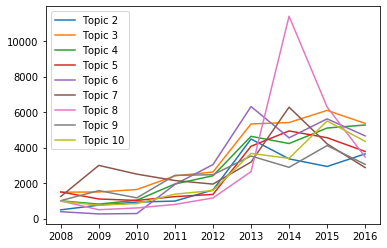

In [303]:
# time dynamic stuff: Want to cluster topics occurences by year:
topic_count_per_year = np.zeros((num_topics, 9))
date_idx_map = dict(zip(range(2008,2017), range(0,10)))

for idx, t in enumerate(topic_assignment):
    year = int(stemmed_dates[idx].split('-')[0])
    topic_count_per_year[t,date_idx_map[year]] += 1
    
topic_count_by_year_df = pd.DataFrame(topic_count_per_year, columns = range(2008,2017), index = ['Topic ' + str(i) for i in range(1,11)])
topic_count_by_year_df.iloc[1:,:].T.plot()


Interestingly, it looks like news about Russia (topic 8) and Israel (topic 7) peaked in 2014, but otherwise there is a general upward trends in all the news counts, suggesting that Reddit became more widely used over time. 

# 3. Conclusions
In this section, I summarize the major analysis insights:

1. The vast majority (64%) of users post only once over the course of 9 years. Of the unique 85838 users in the dataset, 595 (0.7%) of them are **active**, meaning they posted at least 100 times over 9 years. However, these active users post in spurts of activity, rather than being consistently active across all 9 years. <br/><br/>
The above analysis suggests a weakness in the user churn rate. It is very likely that many users post once or twice and then stop using Reddit. Reddit might therefore consider encouraging users to be more active by creating special membership statuses for users that post a minimum amount every month, for example.


2. The articles cluster into about 10 different topics, 7 of which cluster nicely by country and the remaining 3 are more conceptual. These 10 topics provide insight into trending topics in world news, and Reddit can monetize this by selling ads based on these topics. For example, there are 26471 article titles that classify into the 'China' category. This suggests that users might click on ads related to Chinese products out of curiosity. <br/><br/>
Unfortunately, because the down_vote column of the dataset is uniquely 0, we cannot use the up_vote information to provide any signal into user sentiment analysis, because up voting alone could simply mean that the user finds the article subject interesting rather than that he or she likes the content being discussed. However, we still compute the average number of upvotes per topic and show that 'USA'-articles have the highest average upvote, which may or may not suggest that the US remains a popular country amongst users. This would not be surprising given that the vast majority of Reddit users live in the US.